# Time Series: Trend Detection (Sea Surface Temperatures)

# Introduction

In this lab we will explore the available MODIS datasets and create a sea-surface temperature (SST) time series with MODIS. We will also explore some python graphing libraries to create interactive plots of earth engine data.


# Setup

Let's install the necessary libraries and set up our GEE instance.

In [2]:
# Import the necessary libraries
import ee
import numpy as np
import geemap as geemap
import pprint
import pandas as pd
import altair as alt
import folium

# Set up a 'pretty printer' to print ...
pp = pprint.PrettyPrinter(depth=3)

In [3]:
# Authenticate and initialize this instance of GEE in Google Colab
## Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize(project = 'ee-cptcitrus-main')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


# MODIS

MODIS (or Moderate Resolution Imaging Spectroradiometer) is an instrument aboard two complimentary satellites launched by NASA: **Terra** and **Aqua**. Combined, the Terra and Aqua MODIS instruments image the entire surface of the Earth every 1 to 2 days, acquiring data in 36 spectral bands at 250 m (bands 1–2), 500 m (bands 3–7), and 1000 m (bands 8–36) resolution.

With its low spatial resolution but high temporal resolution, MODIS data are useful to track changes across large areas over time.

MODIS has pre-calculated data products in addition to the 36 band imagery that you can access from the GEE catalogue. Check out all the available data in the [MODIS section of the GEE catalogue](https://developers.google.com/earth-engine/datasets/catalog/modis).

The structure of MODIS data is a bit more complicated than what we have dealt with so far. The data from MODIS is processed by a variety of groups (depending on the product) in order to create the available data products. Unlike some other satellite data, MODIS does not provide unprocessed scenes to the general public.

### Using MODIS Surface Reflectance

To start, we will use the MOD09GA.006 Terra Surface Reflectance Daily Global 1km and 500m daily data product. This collection has surface reflectance available at 500m resolution, as well as pixel quality assurance (QA) bit information at 1000m resolution. These QA bits contain information about cloud contamination, as well as the number of observations that make up a given pixel -- remember, these pixels are data ***products*** and so can represent >1 observation.

Masking unwanted pixels is done in a similar way as for Landsat, using the MODIS pixel QA bands. In this case we will create functions to mask both cloud pixels (from the `state_1km` QA band) and pixels with no observations (from the `num_observation_1km` band).

Pixels with no observations can occur due to sensor malfunctions, extreme conditions, and many other reasons. The important thing is that we don't want to include them in our images because they may interfer with calculations we perform using the pixel values.

In [4]:
# Calculate how frequently a location is labeled as clear (i.e. non-cloudy)
# According to the "internal cloud algorithm flag" of the MODIS "state 1km" QA band.

# A function to mask out pixels that did not have observations
def maskEmptyPixels(image):
  # Find pixels with >0 observations and mask out all other pixels
  withObs = image.select('num_observations_1km').gt(0)
  return image.updateMask(withObs)

# A function to mask out cloudy pixels
def maskClouds(image):
  # Select the QA band.
  QA = image.select('state_1km')
  # Make a mask to get bit 10, the internal_cloud_algorithm_flag bit.
  bitMask = 1 << 10
  # Return an image masking out cloudy areas.
  return image.updateMask(QA.bitwiseAnd(bitMask).eq(0))


Now let's apply the masking functions to a collection and display it on the map

In [5]:
# Start with an image collection for summer 2010 and apply masks
summer2010 = ee.ImageCollection('MODIS/006/MOD09GA')\
        .filterDate('2010-04-01', '2010-09-30')\
        .map(maskEmptyPixels)\
        .map(maskClouds)

# Get the median pixel value for summer 2010
# Recall from the last lab that this is a temporal reducer
summer2010med = summer2010.median()

# Note that true colour for this MODIS dataset is Band 1 in Red, Band 4 in Green, and Band 3 in Blue
visParams = {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
     'gain': 0.07,
     'gamma': 1.4
    }

Map = geemap.Map()
Map.addLayer(summer2010med,visParams,'Summer 2010 Median SR')
Map.addLayerControl()
Map.setCenter(41.92,32.36,5)
Map


#
#
# I've ignored the depreciation warning here.
#
#

C:\Users\cptci\anaconda3\envs\ee\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD09GA! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09GA

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[32.36, 41.92], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

Notice that we did not filter the bounds of the image so we have created a median for the entire globe (where there is data for summer 2010). So you can pan and zoom to any area you like and see what the data look like there.

Because of the high temporal frequency of MODIS, the resulting imagery is pretty great, because the median pixel is potentially calculated from as many as 182 observations. That is, one pixel per day for every day from April 1st to September 30th (182 days).

### Using Other MODIS Data Products

In addition to the surface reflectance products, MODIS also provides special data products calculated from the data. For the next example, we will use the [Ocean Color Standard Mapped Image MODIS Aqua Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI).

This dataset is a level 3 product that includes ocean color and satellite ocean biology data produced by NASA's Earth Science Data Systems (ESDS) program. It includes bands that are useful for calculating ocean biology data because of their narrow wavelengths, as well as some bands of pre-calculated data such as chlorophyll-a concentration and sea-surface temperature (SST).

Let's check out the SST band and use it to look at El Nino and La Nina years. If you need a quick refresher, check out the NASA kid science pages for [El Nino](https://spaceplace.nasa.gov/el-nino/en/) and [La Nina](https://spaceplace.nasa.gov/la-nina/en/).

In [6]:
# Load MODIS Ocean Colour Image Collection
modisOceanColor = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI');

# Create a collection from the SST (sea surface temperature) band
sst = modisOceanColor.select(['sst'])

# Calculate median SST values for winter 2015/2016 - an El Nino year
sstElNino = sst.filterDate('2015-12-01', '2016-02-28').median()

# Calculate median SST values for winter 2010/2011 - a La Nina year
sstLaNina = sst.filterDate('2010-12-01', '2011-02-28').median()


In [12]:
# Create vis parameters for SST with a palette that goes from blue to red
vis = {'min': -4, 'max': 35, 'palette': ['2166AC','4393C3','92C5DE','D1E5F0','B2182B']};

Map = geemap.Map()
Map.addLayer(sstElNino,vis,'El Nino')
Map.addLayer(sstLaNina,vis,'La Nina')
# set the map centre as the middle of the Pacific at a zoom level of two (pretty zoomed out)
Map.setCenter(-146.25,0,2)
Map.addLayerControl()
Map

Map(center=[0, -146.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

Toggle the layers on and off to compare the sea surface temperature for El Nino and La Nina years.

Recall from your climatology courses (or the NASA Kids pages linked above) that El Nino results from weaker trade winds moving from East to West resulting in warmer waters toward the west coast of Central/South America. La Nina occurs in years with stronger than normal trade winds, resulting in cooler waters off the west coast of Central/South America.

The effect of the El Niño-Southern Oscillation (ENSO) is best visualized as a temperature anomaly in order to show the effect on areas that still have relatively cool waters, rather than an absolute temperature which shows 10-degree water as light blue, regardless of whether 10 degrees is colder or warmer than normal conditions. However, these two layers still do a decent job of showing how MODIS can be used to look at large scale data patterns.

# Time Series Charts with MODIS

Time series analysis involves looking at data over time to detect and describe change. With imagery this can be done in the form of a video, or, more simply, by extracting some data from the imagery and displaying the change through time on a graph.

The Google Earth Engine Code Editor has a built in charting library called Chart.UI that integrates some Earth Engine functionality like reducers into chart functions to create easy data visualizations.

Unfortunately, Chart.UI does not work in the python API, so we need to create some reducing functions that we can apply to the image collections before plotting with some normal python charting libraries. We will look at two charting libraries in this lab: the simple **matplotlib**, and **Altair**, which is a library that is useful for creating nice interactive maps.

## Create the Reducing Function

In order to create a time series analysis, we can either look at the change in pixel values over time for a **single pixel** (at a defined point), or we can look at the change in values over time for a **region of pixels** (within a defined geometry). In both cases, we need to use a reducer to summarize the values for an area before plotting the time series. We have used reducers before in previous labs.

As mentioned, the Chart.UI library incorporates this reducing capability into its chart functions, but in the Python API in colab, we need to define the functions that will apply a reducer across an image collection before we plot the time series. The functions below were taken directly from a [GEE Python Charting Tutorial ](https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb).

The first function is actually used to create another function, in a fairly nifty bit of python. The code below defines a reusable function that can perform the reducing task for different datasets. The function accepts arguments such as scale and reduction method to parameterize the operation for each particular analysis.

Do not worry too much about trying to understand *how* the function works. For our purposes, we just need to know that they work (they do) and that we can re-use them to convert image collections to tables.

In [13]:
# Define a function (and embedded function) for reducing a region for charting
# See the function descriptions defined in red within the functions

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.median(),
                                  scale=500,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

Now that we have defined our functions, we can use them on an image collection and a region in order to get a table we can use as input to some charting library functions.

In [14]:
# Load MODIS Ocean Colour Image Collection
modisOceanColor = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI');

# Create a collection from the SST (sea surface temperature) band
sst = modisOceanColor.select(['sst'])

# Define an area of interest (aoi)
# We will look at Lake Erie
aoi = ee.Geometry.Polygon([[-83.594,41.326],
                           [-78.782,41.326],
                           [-78.782,42.972],
                           [-83.594,42.972],
                           [-83.594,41.326]])


In [15]:
# Check out the AOI if you want
# If you know where Lake Erie is, feel free to skip this cell
Map = geemap.Map()
Map.addLayer(aoi,{},'AOI')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

The next code chunk does three things:
1. Assigns the reduce function with specific parameters to the function, `reduce_sst`. This will make it simpler to map the function across the image collection.
2. Maps the function over the `sst` image collection to reduce each image.
3. Filters out any resulting features that have null computed values (occurs when all pixels in an AOI are masked).

In [16]:
# Use the above defined function to create a reducing function specific to the SST dataset
## We are going to leave most of the arguments as their defaults (see the above code)
## except geometry which we set to our aoi, the reducer which we will set as the median
reduce_sst = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.median())

# Convert the image collection to a feature collection with the reducer function
## this step just applies the function we created above (reduce_sst), with its defined inputs to our
## image collection
sst_stat_fc = ee.FeatureCollection(sst.map(reduce_sst))

# Filter out null values based on bandnames of the first image in the feature collection
sst_stat_fc = sst_stat_fc.filter(ee.Filter.notNull(sst.first().bandNames()))

The next step to format the data for charting is to create an `fc_to_dict` function to convert the `ee.FeatureCollection` to an `ee.Dictionary`. Then we convert the `ee.Dictionary` to a pandas dataframe, which is a common table format in python.

Recall that Google Earth Engine works by sending code between your computer in the python API and Google's servers for computation. In order to plot charts without Google's built in Chart.UI functioning, we need to transfer the data from Google's server (often referred to in documentation as 'server side') to our own computers (referred to as 'client side'), which we do with the `.getInfo()` call.

This workflow is very useful for integrating Google Earth Engine data with other python libraries and data processing functions, not just for charting.

But now back to charting...

In [17]:
# Define a function to transfer feature properties to a dictionary.
# We use this to convert our earth engine object (reduced image collection) to a
# collection of properties and their values

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

Now we need to get the data, in the form of a dictionary, on to our own computer. This can take a little bit of time because data transfer from Google's servers to your computer is (deliberately) slow, even if the amount of data is very small. Running the cell below should take a few minutes. It may time out (colab imposes a maximum amount of time each opration can take). If it does, try again and it should work.

In [18]:
# Convert feature collection to dictionary and use .getInfo() to transfer to our own computers
sst_dict = fc_to_dict(sst_stat_fc).getInfo()


Now let's see what the dictionary looks like.

In [19]:
# print normally
print(sst_dict,"\n") # \n tells it to print a new line

# print some of the dictionary with formatting
for prop in sst_dict.keys():
    print(prop + ':', sst_dict[prop][0:3] + ['...'])

{'millis': [1025744101000, 1025828100000, 1025916600000, 1026000301000, 1026088800000, 1026172811000, 1026261001000, 1026349200000, 1026433201000, 1026521701000, 1026605401000, 1026693901000, 1026777601000, 1026866101000, 1026950401000, 1027038301000, 1027126501000, 1027210500000, 1027382700000, 1027471200000, 1027555200000, 1027643400000, 1027815601000, 1027904100000, 1028681401000, 1028765100000, 1028853600000, 1028937601000, 1029025800000, 1029198001000, 1029370201000, 1029458701000, 1029542401000, 1029630901000, 1029803101000, 1029891301000, 1030063801000, 1030147500000, 1030236001000, 1030320000000, 1030408200000, 1030495500000, 1030580400000, 1030667401000, 1030752601000, 1030841100000, 1030924801000, 1031013301000, 1031100601000, 1031185501000, 1031272501000, 1031357701000, 1031444700000, 1031529901000, 1031616601000, 1031702400000, 1031877601000, 1031962800000, 1032135001000, 1032221701000, 1032307201000, 1032393901000, 1032482701000, 1032567901000, 1032654901000, 1032740101000

In the dictionary:
- 'millis' is milliseconds since January 1st, 1970, also known as the UNIX Epoch. It's not easily readable for humans, but can be converted to a date and time [online](https://www.epochconverter.com/) if you like.
- 'sst' is the Sea Surface Temperature, in degrees Celcius.
- 'system:index' is a unique identifier of the data product the information comes from.

In the dictionary format, lists of data are stored in properties in the format `{property1: [list of values1], property2: [list of values2]...}`. This can easily be converted to a dataframe by creating columns from the properties. To do that we will use the .DataFrame() function from the pandas library (which we imported as pd).


In [20]:
# Convert the dictionary to a dataframe to make the information easier to interpret
sst_df = pd.DataFrame(sst_dict)

Now let's see what the dataframe looks like.

In [21]:
sst_df

,millis,sst,system:index
0,1025744101000,24.281767,A2002185
1,1025828100000,23.463994,A2002186
2,1025916600000,24.027574,A2002187
3,1026000301000,23.096818,A2002188
4,1026088800000,24.217818,A2002189
...,...,...,...
4979,1645402201000,0.650178,A2022052
4980,1645574401000,0.200000,A2022054
4981,1645663201000,-0.405000,A2022055
4982,1645748401000,-0.560000,A2022056


The data is easier to read and easier to manipulate when it is in the dataframe (table) format.

The next step is to clean up the data before plotting. We will convert the `millis` property to a format that is more intuitive and then create year, month, day, and day of the year (DOY) variables from it.

And at the same time we can drop the system index column, since we don't need it.

In [26]:
# Function to add date variables to DataFrame.
# This function just uses pandas functions on the millis column to create date time columns

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [27]:
# apply the date info function to the dataframe
sst_df = add_date_info(sst_df)

# Rename the sst column SST and remove the unnecessary millis and system:index columns
sst_df = sst_df.rename(columns={
    'sst': 'SST'
}).drop(columns=['millis', 'system:index'])

Now let's see what our cleaned up dataframe looks like.

In [28]:
sst_df

,SST,Timestamp,Year,Month,Day,DOY
0,24.281767,2002-07-04 00:55:01,2002,7,4,185
1,23.463994,2002-07-05 00:15:00,2002,7,5,186
2,24.027574,2002-07-06 00:50:00,2002,7,6,187
3,23.096818,2002-07-07 00:05:01,2002,7,7,188
4,24.217818,2002-07-08 00:40:00,2002,7,8,189
...,...,...,...,...,...,...
4979,0.650178,2022-02-21 00:10:01,2022,2,21,52
4980,0.200000,2022-02-23 00:00:01,2022,2,23,54
4981,-0.405000,2022-02-24 00:40:01,2022,2,24,55
4982,-0.560000,2022-02-25 00:20:01,2022,2,25,56


## Plotting the Dataframe

The hard part is over. We now have our reduced (i.e. summarized) Earth Engine data in a table format. If you wanted to, you could export the table to a .csv and create a simple graph in Excel. However, once you get used to it, charting in python is excellent and has tons of libraries and functions for creating beautiful custom graphs. Because we are working in a notebook, we can even make them interactive!

We did not filter our image collection by date so our dataframe `sst_df` contains all of the data included in the MODIS Ocean Color Dataset, i.e. the median SST values for our Area Of Interest (AOI) since July 4th 2002. This data product is not quite daily, but it still contains a lot of data for us to visualize.

### Matplotlib

Let's start by creating a scatterplot in matplotlib, which you may have used before. For this plot, we will put SST on the y-axis, and DOY on the x-axis. This allows us to combine data from different years into a single plots of the seasonal variation of SST in Lake Erie.

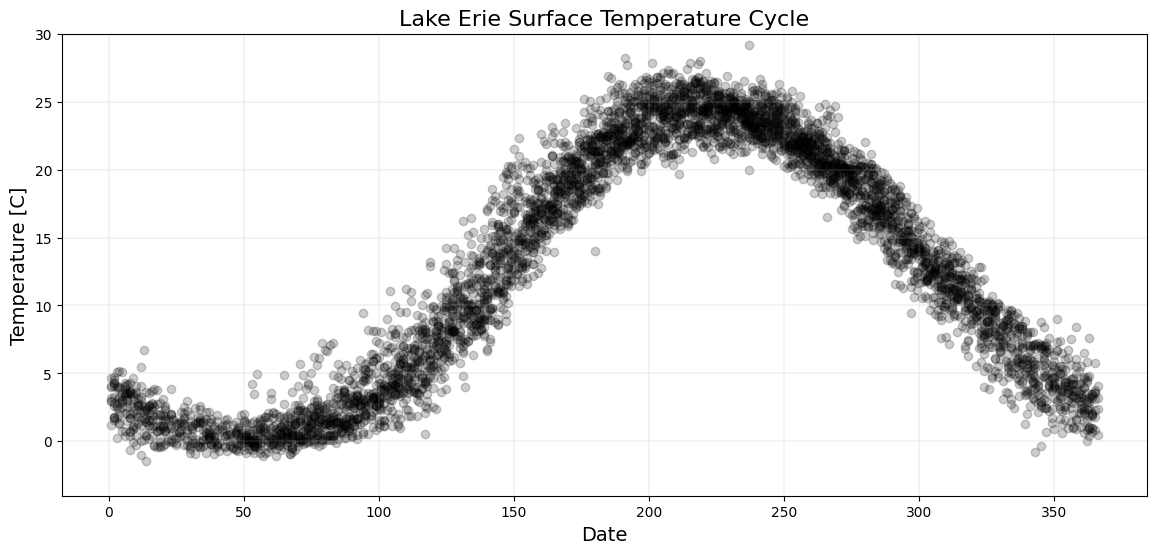

In [29]:
# import matplotlib
import matplotlib.pyplot as plt

# Set up the subplots. This is your base.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plot with blue points that are 20% opaque. Use DOY on the x, and SST on the y axis
ax.scatter(sst_df['DOY'], sst_df['SST'],
           c='black', alpha=0.2)

# Add some parameters.
ax.set_title('Lake Erie Surface Temperature Cycle', fontsize=16) # set the title
ax.set_xlabel('Date', fontsize=14) # set the x-axis label
ax.set_ylabel('Temperature [C]', fontsize=14) # set the y-axis label
ax.set_ylim(-4, 30) # set the y-axis range
ax.grid(lw=0.2) #set the opacity of the background grid to 20%


plt.show()

Our graph shows us about what we would expect for a lake in the northern hemisphere! There seem to be a couple of outliers, but for the most part, the lake surface temperature follows the same pattern for all of our data points.

Matplotlib is a standard that is very customizable (and has tons of support pages across the internet). However, there are other libraries that make it easier to create beautiful visualizations.

For this exercise we will use Altair, but if you're interested, try checking out seaborn as well!

### Altair

The matplotlib chart we created is nice, but it is only presenting some of the information we have because it is not separating out the different years. Let's try another chart with Altair where we plot different years in different colours.

In [30]:
# Set the chart base up
base = alt.Chart(sst_df).encode(
    # set x-axis with DOY (see explanation of Q in comments below)
    # the scale specifies the range of our x-axis
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 370])),
    # set y-axis as SST and set range from -5 to 30
    y=alt.Y('SST:Q', scale=alt.Scale(domain=[-5, 30])),
    # Change the point colours by Year value using the viridis colour scheme
    color=alt.Color('Year:O', scale=alt.Scale(scheme='viridis')))

# add the points to the map as circles
points = base.mark_circle()

# set overall properties
(points).properties(width=600, height=350)

## Note: Altair uses Q and O to specify the kind of data
# Q = quantitative, or continuous data (like SST)
# O = ordinal, or categorical data (like Year)

alt.Chart(...)

This graph now helps us see which years the outliers are in. It seems like the outliers come from many different years -- there is no obvious trend of one year having higher or lower than normal SST.

As mentioned, Altair also allows for interactive charts. Now we can adapt the above code to make it interactive. We will also add lines that connect our points for each year to our chart.

In [33]:
# Set the highlight parameters
# When we hover our mouse over a point, we want all the points that share that year
# to be highlighted
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

# Set the base, this is the same as above.
base = alt.Chart(sst_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 370])),
    y=alt.Y('SST:Q', scale=alt.Scale(domain=[-5, 30])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='turbo')))

# Add points - change the size based on the highlight condition we set above
points = base.mark_circle().encode(
    size=alt.condition(~highlight, alt.value(10), alt.value(15)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('SST:Q', title='SST')
    ]).add_selection(highlight)

# Add lines - change the size based on the highlight condition
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(4)))

# Set the chart properties and add .interactive()
(points + lines).properties(width=600, height=350).interactive()

alt.LayerChart(...)

The above chart is interactive - when you hover over a value, it will give you information about the point. You can also zoom in on the graph and drag it up, down, right, and left.

Interactive maps and charts are a great way to make use of notebook functionality.

### Plot Chlorophyll-a Trend for 2015

For our last example, we will modify our code from above to look at the trend in chlorophyll concentration for 2015. There was a big algal bloom in 2015 in Lake Erie, which we should be able to see if we plot out the values. The code below follows the same structure that we used above for SST, but without all the comments so you see it in a more condensed format.

In [34]:
##### SET UP IMAGE COLLECTION AND AOI #####

# Create a collection from the chlor_a (Chlorophyll-a concentration) band
chla = modisOceanColor.select(['chlor_a'])

# Define an area of interest (aoi)
aoi = ee.Geometry.Polygon([[-83.594,41.326],
                           [-78.782,41.326],
                           [-78.782,42.972],
                           [-83.594,42.972],
                           [-83.594,41.326]])


In [35]:
##### REDUCE IMAGE COLLECTION #####

# Create reducer function for mapping across image collection
reduce_chla = create_reduce_region_function(geometry=aoi, reducer=ee.Reducer.median())

# Map reducing function across image collection and convert it to feature collection
chla_stat_fc = ee.FeatureCollection(chla.map(reduce_chla))

# Clean up by removing null values
chla_stat_fc = chla_stat_fc.filter(ee.Filter.notNull(chla.first().bandNames()))

In [36]:
##### CONVERT COLLECTION TO TABLE #####

# Convert ee feature collection to 'client-side' dictionary
chla_dict = fc_to_dict(chla_stat_fc).getInfo()

# Convert dictionary to dataframe and add date info
chla_df = pd.DataFrame(chla_dict)
chla_df = add_date_info(chla_df)

# Clean up data columns and remove unnecessary columns
chla_df = chla_df.drop(columns=['millis', 'system:index'])

In [37]:
chla_df

,chlor_a,Timestamp,Year,Month,Day,DOY
0,1.664864,2002-07-05 00:15:00,2002,7,5,186
1,1.834026,2002-07-06 00:50:00,2002,7,6,187
2,1.265799,2002-07-07 00:05:01,2002,7,7,188
3,1.432586,2002-07-08 00:40:00,2002,7,8,189
4,1.670316,2002-07-10 00:30:01,2002,7,10,191
...,...,...,...,...,...,...
3860,2.438864,2022-02-18 00:15:00,2022,2,18,49
3861,4.111772,2022-02-20 00:05:00,2022,2,20,51
3862,3.728929,2022-02-21 00:10:01,2022,2,21,52
3863,4.018863,2022-02-24 00:40:01,2022,2,24,55


So far, most of what we have done is the exact same as what we did for sea surface temperature above. We have just changed our band to be `chlor_a` instead of `sst` and we changed our variable names to reflect that change.

Our dataframe contains all of the data since 2002 but we just want data for 2015. We ***could*** have filtered our image collection at the beginning, the same way we did in previous labs, which would have been less data intensive because it would have meant that we didn't need to convert values from all of the other years to a dictionary and a dataframe. However, we can also filter our dataframe, which gives us a bit more flexibility in case we want to plot other years. It also gives us the opportunity to use some pandas functions to filter the table/dataframe.

In [38]:
# Filter dataframe using loc
# This line creates a new dataframe that only include rows from the
# original df that have values of 2015 in the Year column

chla2015_df = chla_df.loc[chla_df['Year'] == 2015]

In [39]:
highlight = alt.selection(
    type='single', on='mouseover', fields=['chlor_a'], nearest=True)

base = alt.Chart(chla2015_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 370]),title = "Day of the Year"),
    y=alt.Y('chlor_a:Q', scale=alt.Scale(domain=[0,15]),title='Chl-a Concentration'),
    # use the goldgreen color scheme and set the variable as Q (continuous)
    color=alt.Color('chlor_a:Q', scale=alt.Scale(scheme='goldgreen')))

points = base.mark_circle().encode(
    size=alt.condition(~highlight, alt.value(100), alt.value(120)),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('chlor_a:Q', title='Chl-a')
    ]).add_selection(highlight)

(points).properties(width=600, height=350).interactive()

alt.Chart(...)

In the chart above, we didn't need to colour the points based on chl-a concentration because it doesn't add any additional information (we already see the Chl-a pattern based on their position on the chart). However, it can be a useful visualization tool to put the focus on the change of values. You can use a single colour by changing the above code for base to this:

```
base = alt.Chart(sst2015_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 370]),title = "Day of the Year"),
    y=alt.Y('chlor_a:Q', scale=alt.Scale(domain=[0,15]),title='Chl-a Concentration'),
    color=alt.value('green'))
```

The chart above shows that there are some pretty high Chl-a values in the late summer. Let's check out what the surface reflectance and Chl-a values look like on a map!

In [42]:
SR_Aug2015 = ee.ImageCollection('MODIS/006/MOD09GA')\
        .filterDate('2015-08-01', '2015-09-30')\
        .filterBounds(aoi)\
        .map(maskEmptyPixels)\
        .map(maskClouds)\
        .median()

SR_May2015 = ee.ImageCollection('MODIS/006/MOD09GA')\
        .filterDate('2015-04-01', '2015-05-31')\
        .filterBounds(aoi)\
        .map(maskEmptyPixels)\
        .map(maskClouds)\
        .median()

Chla_Aug2015 = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI').select(['chlor_a'])\
        .filterDate('2015-08-01', '2015-09-30')\
        .filterBounds(aoi)\
        .median()

Chla_May2015 = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI').select(['chlor_a'])\
        .filterDate('2015-04-01', '2015-05-31')\
        .filterBounds(aoi)\
        .median()

SRvis = {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
     'gain': 0.07,
     'gamma': 1.7
    }

Chlavis = {'min':0,'max':16,'palette': ['blue','teal','green']};

Map = geemap.Map()
Map.addLayer(SR_May2015,SRvis,'May 2015 Median SR')
Map.addLayer(SR_Aug2015,SRvis,'Aug 2015 Median SR')
Map.addLayer(Chla_May2015,Chlavis,'May 2015 Median Chla')
Map.addLayer(Chla_Aug2015,Chlavis,'Aug 2015 Median Chla')
Map.addLayerControl()
Map.centerObject(aoi,8)
Map

Map(center=[42.170565764095706, -81.18800000000007], controls=(WidgetControl(options=['position', 'transparent…

We can definitely see a difference between the surface reflectances for April/May and August/September but the Chl-a values are very different!

This is because Chl-a is calculated using more than just the RGB bands and thus shows more variation that we can discern just from true colour imagery.

# Questions

## Q1 (1 point)

Display the median 2018 SST value for the whole globe on a map. Use `'palette': 'navy, blue, turquoise'` in your visualization parameters. Make sure your minimum and maximum values make sense.

In [48]:
# Start with an image collection for summer 2010 and apply masks
sst2018 =ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
        .filterDate('2018-01-01', '2018-12-31')\
        .select(['sst'])

sst2018med = sst2018.median()


# # Note that true colour for this MODIS dataset is Band 1 in Red, Band 4 in Green, and Band 3 in Blue
visParams = {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
     'gain': 0.07,
     'gamma': 1.4
    }

# Create vis parameters for SST with a palette that goes from blue to red
vis = {'min': -20, 'max': 35, 'palette': ['navy', 'blue', 'turquoise']};

Map = geemap.Map()
Map.addLayer(sst2018med,vis,'2018 Ocean Temperatures')
Map.setCenter(-146.25,0,2)
Map.addLayerControl()
Map

Map(center=[0, -146.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

## Q2 (1 point)

Create a scatter plot showing the median SST over 2018 for an area of your choice anywhere in the world (over water, of course). You can either choose a point, or a rectangle to define your area.

**Describe the trends on the scatterplot.**

You may select your preferred method of plotting. Make sure to indicate where your AOI is.

Hint: you can get latitudes and longitudes by clicking on any map in this notebook or in Google Maps.

In [65]:
#AOI is the caribbean centered on Guadeloupe
aoi = ee.Geometry.Polygon([[
    [-61.6278, 16.1872],
    [-61.6278, 16.3428],
    [-61.4722, 16.3428],
    [-61.4722, 16.1872],
]])

modisOceanColor = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
                    .filterBounds(aoi)
sst = modisOceanColor.select(['sst'])

reduce_sst = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.median())

sst_stat_fc = ee.FeatureCollection(sst.map(reduce_sst))

sst_stat_fc = sst_stat_fc.filter(ee.Filter.notNull(sst.first().bandNames()))

# Convert feature collection to dictionary and use .getInfo() to transfer to our own computers
sst_dict = fc_to_dict(sst_stat_fc).getInfo()

sst_df = pd.DataFrame(sst_dict)
sst_df = add_date_info(sst_df)

In [66]:
sst_df.head()

,millis,sst,system:index,Timestamp,Year,Month,Day,DOY
0,1025744101000,26.799999,A2002185,2002-07-04 00:55:01,2002,7,4,185
1,1025916600000,28.064999,A2002187,2002-07-06 00:50:00,2002,7,6,187
2,1026261001000,28.039999,A2002191,2002-07-10 00:30:01,2002,7,10,191
3,1026521701000,27.420000,A2002194,2002-07-13 00:55:01,2002,7,13,194
4,1026693901000,27.410000,A2002196,2002-07-15 00:45:01,2002,7,15,196


In [68]:

# Set the chart base up
base = alt.Chart(sst_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 370])),
    y=alt.Y('sst:Q', scale=alt.Scale(domain=[10, 40])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='viridis')))

# add the points to the map as circles
points = base.mark_circle()

# set overall properties
(points).properties(width=600, height=350)

alt.Chart(...)

Much warmer than the plot from before.

## Q3 (2 points)

Australia's Great Barrier Reef suffers from coral bleaching when the water around the corals gets too hot. Global warming has increased the frequency of coral bleaching in general, but the worst bleaching typically happens in El Nino or La Nina years (more information [here](https://reefresilience.org/climate-and-ocean-change/el-nino-southern-oscillation/)). Bleaching always happens around the hottest months of the year, which are January-March in this part of the world.

Create an AOI that covers part of the Great Barrier Reef. You can try to cover much of the reef system, or focus on part of it. Plot SSTs for this region using Altair, as in the example above. You will probably need to split it into two plots because Altair can only plot a maximum of 5000 data points per plot. Based on these plots, which year(s) do you think were the worst, to date, for coral bleaching on the Great Barrier Reef? Search the Internet (e.g. [here](https://www.theguardian.com/environment/2020/apr/07/great-barrier-reefs-third-mass-bleaching-in-five-years-the-most-widespread-ever)) to see if your analysis matches reality.

**Note:** The graphs you make are not going to present a crystal-clear picture, which is ok. It will take some experimentation to nail down the plot parameters.

In [70]:
aoi = ee.Geometry.Polygon([[
[147.6357,  -18.3506],
[147.6357,  -18.2236],
[147.7627,  -18.2236],
[147.7627,  -18.3506],
]])


modisOceanColor = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
                    .filterBounds(aoi)
sst = modisOceanColor.select(['sst'])

reduce_sst = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.median())

sst_stat_fc = ee.FeatureCollection(sst.map(reduce_sst))

sst_stat_fc = sst_stat_fc.filter(ee.Filter.notNull(sst.first().bandNames()))

# Convert feature collection to dictionary and use .getInfo() to transfer to our own computers
sst_dict = fc_to_dict(sst_stat_fc).getInfo()

sst_df = pd.DataFrame(sst_dict)
sst_df = add_date_info(sst_df)



In [83]:

sst_df_1  = sst_df.loc[sst_df['Year'] <= 2011]
sst_df_2  = sst_df.loc[sst_df['Year'] > 2011]

sst_df['time']=sst_df['Year']+sst_df['DOY']/365

# Set the chart base up
base = alt.Chart(sst_df).encode(
    x=alt.X('time:Q', scale=alt.Scale(domain=[2002, 2024])),
    y=alt.Y('sst:Q', scale=alt.Scale(domain=[10, 40])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='viridis')))

# add the points to the map as circles
points = base.mark_circle()

# set overall properties
(points).properties(width=600, height=350)

alt.Chart(...)

Recent years are hotter, with spikes apparently occuring in 2017, 2018, 2020 (maybe) and 2022.